In [1]:
import time
import tracemalloc
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

from scipy.stats import spearmanr, kendalltau, iqr
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import normalized_mutual_info_score, accuracy_score
from sklearn.inspection import permutation_importance

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
# ==========================================
# UTILITY FUNCTIONS
# ==========================================

def freedman_diaconis_bins(x):
    """Calculates bin count using Freedman-Diaconis rule."""
    q75, q25 = np.percentile(x, [75 ,25])
    iqr_val = q75 - q25
    if iqr_val == 0:
        return 10 # Fallback
    h = 2 * iqr_val * (len(x) ** (-1/3))
    if h == 0: return 10
    bins = int((np.max(x) - np.min(x)) / h)
    return max(2, bins) # Ensure at least 2 bins

def compute_nmi_feature_target(X, y):
    """Computes NMI for each feature against target using FD binning."""
    nmi_scores = []
    for col in X.columns:
        # Bin the continuous feature
        n_bins = freedman_diaconis_bins(X[col])
        # pd.cut handles the binning
        X_binned = pd.cut(X[col], bins=n_bins, labels=False)
        score = normalized_mutual_info_score(y, X_binned)
        nmi_scores.append(score)
    return np.array(nmi_scores)

def gini_coefficient(x):
    """Compute Gini coefficient of array of values (measure of inequality/concentration)."""
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    return 0.5 * rmad

def measure_resources(func, *args, **kwargs):
    """Wrapper to measure wall-clock time and peak memory."""
    tracemalloc.start()
    start_time = time.time()
    
    result = func(*args, **kwargs)
    
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    time_taken = end_time - start_time
    memory_mb = peak / (1024 * 1024)
    return result, time_taken, memory_mb

In [3]:
# ==========================================
# DATA SETUP
# ==========================================

print("Loading Data...")
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data for Logistic Regression (XGBoost handles unscaled, but we use scaled for consistency in visualization)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Train Models
print("Training Models...")
# Logistic Regression
lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(X_train_scaled, y_train)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train) # XGB uses unscaled usually, but works either way

Loading Data...
Training Models...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [12]:
rankings

,Pearson,NMI,LR_Coef,LR_PFI,LR_SHAP,XGB_Gain,XGB_PFI,XGB_SHAP
mean radius,7.0,8.0,19.0,25.5,19.0,10.0,13.5,24.0
mean texture,19.0,18.0,21.0,28.0,20.0,9.0,3.0,9.0
mean perimeter,5.0,7.0,20.0,18.0,21.0,28.5,13.5,28.5
mean area,8.0,10.0,18.0,25.5,18.0,11.0,25.5,13.0
mean smoothness,21.0,23.0,29.0,12.5,28.0,18.0,13.5,12.0
mean compactness,11.0,14.0,16.0,10.0,13.0,25.0,13.5,18.0
mean concavity,9.0,6.0,9.0,23.5,9.0,14.0,13.5,16.0
mean concave points,2.0,1.0,4.0,2.0,2.0,2.0,27.0,1.0
mean symmetry,22.0,24.0,24.0,30.0,24.0,28.5,13.5,28.5
mean fractal dimension,28.0,28.0,28.0,20.0,29.0,21.0,13.5,19.0



--- Experiment A: Rank Agreement ---


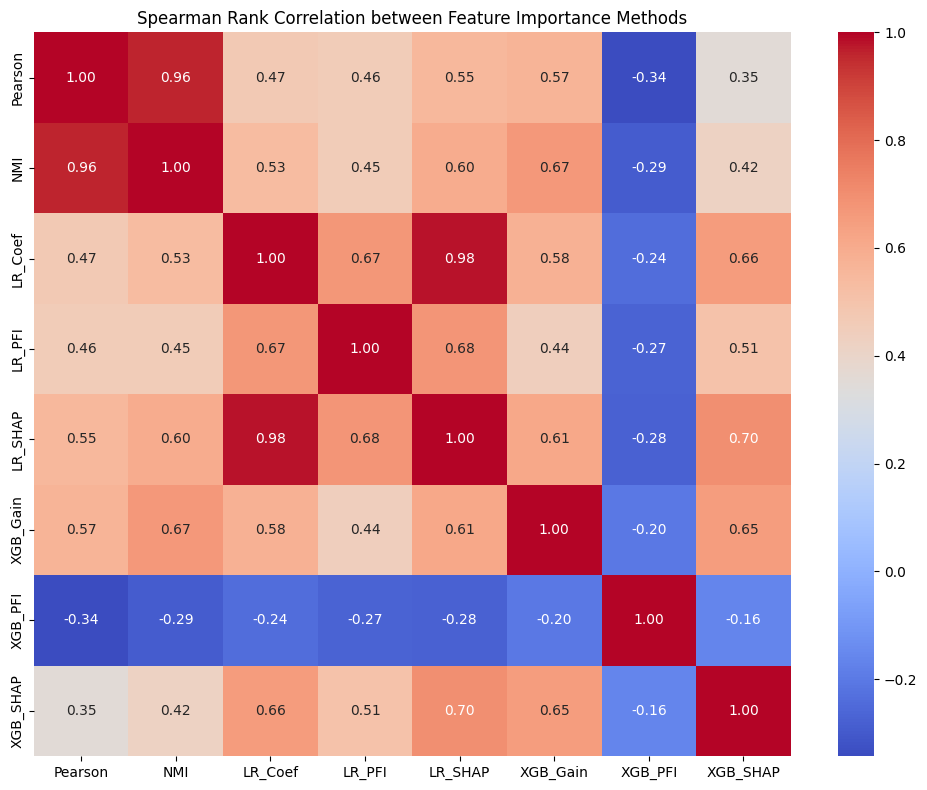

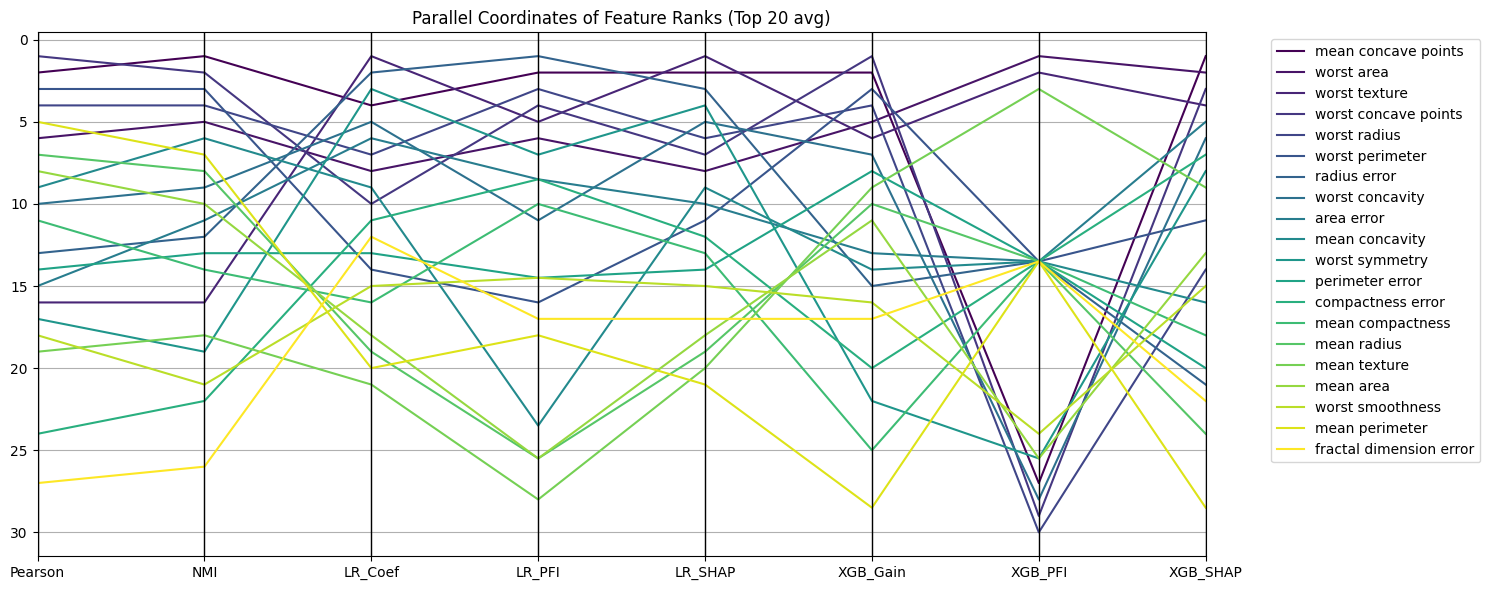

In [ ]:
# ==========================================
# EXPERIMENT A: Rank Agreement
# ==========================================
print("\n--- Experiment A: Rank Agreement ---")

# 1. Pearson Correlation (Linear dependence)
pearson_corr = X_train.corrwith(pd.Series(y_train, index=X_train.index)).abs()

# 2. NMI (Non-linear dependence)
nmi_scores = compute_nmi_feature_target(X_train, y_train)
nmi_series = pd.Series(nmi_scores, index=X_train.columns)

# 3. Model-Based Importances
# LR Coefficients
lr_coef = pd.Series(np.abs(lr_model.coef_[0]), index=X_train.columns)

# XGBoost Native Gain
xgb_native = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# 4. Permutation Feature Importance (PFI)
# Note: PFI should be calculated on Test/Validation set to avoid overfitting bias
pfi_lr = permutation_importance(lr_model, X_test_scaled, y_test, n_repeats=50, random_state=42)
pfi_lr_series = pd.Series(pfi_lr.importances_mean, index=X_train.columns)

pfi_xgb = permutation_importance(xgb_model, X_test, y_test, n_repeats=50, random_state=42)
pfi_xgb_series = pd.Series(pfi_xgb.importances_mean, index=X_train.columns)

# 5. SHAP (TreeExplainer for XGB, LinearExplainer for LR)
explainer_lr = shap.LinearExplainer(lr_model, X_train_scaled)
shap_values_lr = explainer_lr.shap_values(X_test_scaled)
# For binary LR, shap_values might be a list or array. LinearExplainer usually returns array.
shap_lr_summary = np.abs(shap_values_lr).mean(axis=0) 
shap_lr_series = pd.Series(shap_lr_summary, index=X_train.columns)

explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap_xgb_summary = np.abs(shap_values_xgb).mean(axis=0)
shap_xgb_series = pd.Series(shap_xgb_summary, index=X_train.columns)

# Consolidate Ranks
rankings = pd.DataFrame({
    'Pearson': pearson_corr.rank(ascending=False),
    'NMI': nmi_series.rank(ascending=False),
    'LR_Coef': lr_coef.rank(ascending=False),
    'LR_PFI': pfi_lr_series.rank(ascending=False),
    'LR_SHAP': shap_lr_series.rank(ascending=False),
    'XGB_Gain': xgb_native.rank(ascending=False),
    'XGB_PFI': pfi_xgb_series.rank(ascending=False),
    'XGB_SHAP': shap_xgb_series.rank(ascending=False)
})

# Calculate Pairwise Spearman Correlation between rankings
rank_corr_matrix = rankings.corr(method='spearman')

# Visualization: Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(rank_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Rank Correlation between Feature Importance Methods")
plt.tight_layout()
plt.show()

# Visualize Top 20 Features Parallel Coordinates (Rank Plot)
top_20_features = rankings.mean(axis=1).nsmallest(20).index
rankings_top20 = rankings.loc[top_20_features]

plt.figure(figsize=(15, 6))
pd.plotting.parallel_coordinates(rankings_top20.reset_index(), 'index', colormap='viridis')
plt.gca().invert_yaxis() # Rank 1 is top
plt.title("Parallel Coordinates of Feature Ranks (Top 20 avg)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
nmi_series

mean radius                0.232629
mean texture               0.093184
mean perimeter             0.238928
mean area                  0.229365
mean smoothness            0.062197
mean compactness           0.147888
mean concavity             0.251016
mean concave points        0.309483
mean symmetry              0.058340
mean fractal dimension     0.032562
radius error               0.157148
texture error              0.020843
perimeter error            0.150917
area error                 0.210609
smoothness error           0.017761
compactness error          0.068065
concavity error            0.097644
concave points error       0.086385
symmetry error             0.039089
fractal dimension error    0.041308
worst radius               0.280571
worst texture              0.100317
worst perimeter            0.297354
worst area                 0.280143
worst smoothness           0.073518
worst compactness          0.144391
worst concavity            0.231298
worst concave points       0


--- Experiment E: Effect of Multicollinearity ---
Analyzing correlated group: ['mean radius', 'mean perimeter', 'mean area']
Correlation matrix of group:
                mean radius  mean perimeter  mean area
mean radius        1.000000        0.997850   0.986609
mean perimeter     0.997850        1.000000   0.985985
mean area          0.986609        0.985985   1.000000

Concentration Metrics:
Pearson Importance Distribution: [0.7181 0.7319 0.6952] | Gini (Concentration): 0.011
NMI Importance Distribution: [0.2326 0.2389 0.2294] | Gini (Concentration): 0.009
LR Coef Importance Distribution: [0.4319 0.3934 0.4652] | Gini (Concentration): 0.037
LR SHAP Importance Distribution: [0.3388 0.3108 0.3482] | Gini (Concentration): 0.025
XGB SHAP Importance Distribution: [0.0345 0.     0.3037] | Gini (Concentration): 0.599
Generating SHAP Dependence Plot for 'mean radius' vs 'mean area'...


<Figure size 800x600 with 0 Axes>

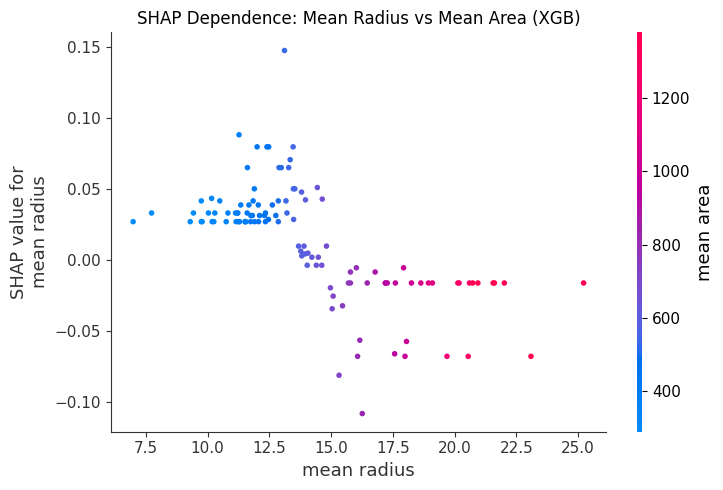

In [13]:
# ==========================================
# EXPERIMENT E: Multicollinearity
# ==========================================
print("\n--- Experiment E: Effect of Multicollinearity ---")
# Breast cancer dataset has high correlation groups: Radius, Perimeter, Area are geometrically linked.
correlated_group = ['mean radius', 'mean perimeter', 'mean area']
print(f"Analyzing correlated group: {correlated_group}")

# Check Correlation among themselves
print("Correlation matrix of group:")
print(X_train[correlated_group].corr())

# Metric: Gini Impurity of Importance (Concentration)
# If Gini is high, importance is concentrated in one feature. If low, it is shared.
def analyze_concentration(series, name):
    group_vals = series[correlated_group].values
    # Handle negative importances (possible in PFI) by taking abs
    group_vals = np.abs(group_vals) 
    gini = gini_coefficient(group_vals)
    print(f"{name} Importance Distribution: {np.round(group_vals, 4)} | Gini (Concentration): {gini:.3f}")

print("\nConcentration Metrics:")
analyze_concentration(pearson_corr, "Pearson")
analyze_concentration(nmi_series, "NMI")
analyze_concentration(lr_coef, "LR Coef")
analyze_concentration(shap_lr_series, "LR SHAP")
analyze_concentration(shap_xgb_series, "XGB SHAP")

# SHAP Dependence Plot for interaction
# We use XGBoost SHAP values for this as trees capture interactions better
print("Generating SHAP Dependence Plot for 'mean radius' vs 'mean area'...")
try:
    plt.figure(figsize=(8, 6))
    shap.dependence_plot("mean radius", shap_values_xgb, X_test, interaction_index="mean area", show=False)
    plt.title("SHAP Dependence: Mean Radius vs Mean Area (XGB)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Skipping plot due to library version issue: {e}")


--- Experiment F: Runtime and Memory ---


PermutationExplainer explainer: 51it [00:24,  2.02it/s]                        
PermutationExplainer explainer: 51it [00:16,  1.31it/s]                        

               Method   Model    Time(s)  Memory(MB)
0       PFI (50 reps)  LogReg   4.063913    0.193523
1       PFI (50 reps)     XGB  49.045040    0.624898
2        SHAP (Aware)  LogReg   0.005363    0.129046
3        SHAP (Aware)     XGB   0.096714    0.698457
4  SHAP (Permutation)  LogReg  24.812569   36.155484
5  SHAP (Permutation)     XGB  16.798148    7.299983


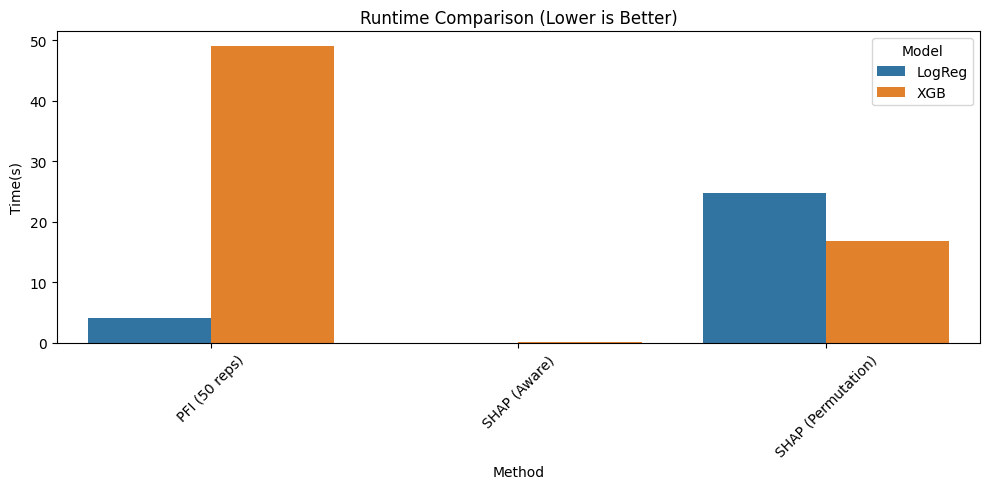

In [14]:
# ==========================================
# EXPERIMENT F: Runtime & Computation Cost
# ==========================================
print("\n--- Experiment F: Runtime and Memory ---")

results_f = []

def run_pfi_50(model, X, y):
    permutation_importance(model, X, y, n_repeats=50, random_state=42)

def run_shap_model_aware_lr(model, X):
    explainer = shap.LinearExplainer(model, X)
    explainer.shap_values(X)

def run_shap_model_aware_xgb(model, X):
    explainer = shap.TreeExplainer(model)
    explainer.shap_values(X)

def run_shap_agnostic_permutation(model, X):
    # Using PermutationExplainer as the model-agnostic method
    # Use a small background dataset for speed (kmeans summary) if dense, 
    # but PermutationExplainer handles this differently. 
    # Usually requires a predict function.
    
    # We use a lambda to ensure the correct predict method is called
    predict_fn = model.predict_proba if hasattr(model, 'predict_proba') else model.predict
    
    # Using a masker is required for PermutationExplainer. 
    # "partition" is good for correlated features, "independent" for uncorrelated.
    masker = shap.maskers.Independent(X, max_samples=100) 
    explainer = shap.PermutationExplainer(predict_fn, masker)
    
    # Limit to first 50 samples for runtime feasibility in this demo script
    explainer(X[:50])

# 1. PFI (LR)
_, t, m = measure_resources(run_pfi_50, lr_model, X_test_scaled, y_test)
results_f.append({'Method': 'PFI (50 reps)', 'Model': 'LogReg', 'Time(s)': t, 'Memory(MB)': m})

# 2. PFI (XGB)
_, t, m = measure_resources(run_pfi_50, xgb_model, X_test, y_test)
results_f.append({'Method': 'PFI (50 reps)', 'Model': 'XGB', 'Time(s)': t, 'Memory(MB)': m})

# 3. SHAP Aware (LR)
_, t, m = measure_resources(run_shap_model_aware_lr, lr_model, X_test_scaled)
results_f.append({'Method': 'SHAP (Aware)', 'Model': 'LogReg', 'Time(s)': t, 'Memory(MB)': m})

# 4. SHAP Aware (XGB)
_, t, m = measure_resources(run_shap_model_aware_xgb, xgb_model, X_test)
results_f.append({'Method': 'SHAP (Aware)', 'Model': 'XGB', 'Time(s)': t, 'Memory(MB)': m})

# 5. SHAP Agnostic (LR) - Approximated on subset
_, t, m = measure_resources(run_shap_agnostic_permutation, lr_model, X_test_scaled)
results_f.append({'Method': 'SHAP (Permutation)', 'Model': 'LogReg', 'Time(s)': t, 'Memory(MB)': m})

# 6. SHAP Agnostic (XGB) - Approximated on subset
_, t, m = measure_resources(run_shap_agnostic_permutation, xgb_model, X_test)
results_f.append({'Method': 'SHAP (Permutation)', 'Model': 'XGB', 'Time(s)': t, 'Memory(MB)': m})

df_results_f = pd.DataFrame(results_f)
print(df_results_f)

# Plot Runtime
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results_f, x='Method', y='Time(s)', hue='Model')
plt.title("Runtime Comparison (Lower is Better)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


--- Experiment G: Model Dependency ---
Top 10 Features overlap: 7
Jaccard Similarity Index: 0.54

Features in both models' Top 10:
['worst texture', 'worst concavity', 'worst symmetry', 'area error', 'mean concave points', 'worst concave points', 'worst area']

Features unique to XGB (Non-linear?):
['symmetry error', 'compactness error', 'mean texture']

Features unique to LR (Linear?):
['worst radius', 'mean concavity', 'radius error']


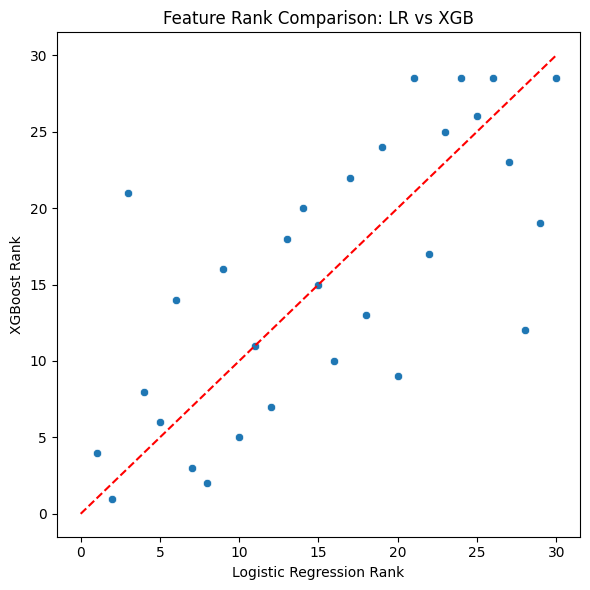

In [15]:
# ==========================================
# EXPERIMENT G: Model-Agnostic vs Model-Aware
# ==========================================
print("\n--- Experiment G: Model Dependency ---")

# Compare Top 10 Features found by LR vs XGB (using SHAP as the gold standard for attribution)
top_n = 10
top_lr = shap_lr_series.nlargest(top_n).index
top_xgb = shap_xgb_series.nlargest(top_n).index

intersection = set(top_lr).intersection(set(top_xgb))
jaccard = len(intersection) / len(set(top_lr).union(set(top_xgb)))

print(f"Top {top_n} Features overlap: {len(intersection)}")
print(f"Jaccard Similarity Index: {jaccard:.2f}")
print("\nFeatures in both models' Top 10:")
print(list(intersection))
print("\nFeatures unique to XGB (Non-linear?):")
print(list(set(top_xgb) - set(top_lr)))
print("\nFeatures unique to LR (Linear?):")
print(list(set(top_lr) - set(top_xgb)))

# Rank comparison plot
comp_df = pd.DataFrame({'LR_Rank': shap_lr_series.rank(ascending=False), 
                        'XGB_Rank': shap_xgb_series.rank(ascending=False)})
plt.figure(figsize=(6, 6))
sns.scatterplot(data=comp_df, x='LR_Rank', y='XGB_Rank')
plt.plot([0, 30], [0, 30], 'r--') # Diagonal perfect agreement
plt.title("Feature Rank Comparison: LR vs XGB")
plt.xlabel("Logistic Regression Rank")
plt.ylabel("XGBoost Rank")
plt.tight_layout()
plt.show()